In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer

In [23]:
url='https://raw.githubusercontent.com/digipodium/Datasets/main/regression/diamonds.csv'

In [24]:
df = pd.read_csv(url, index_col=0)
df

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [25]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


# handling skewness

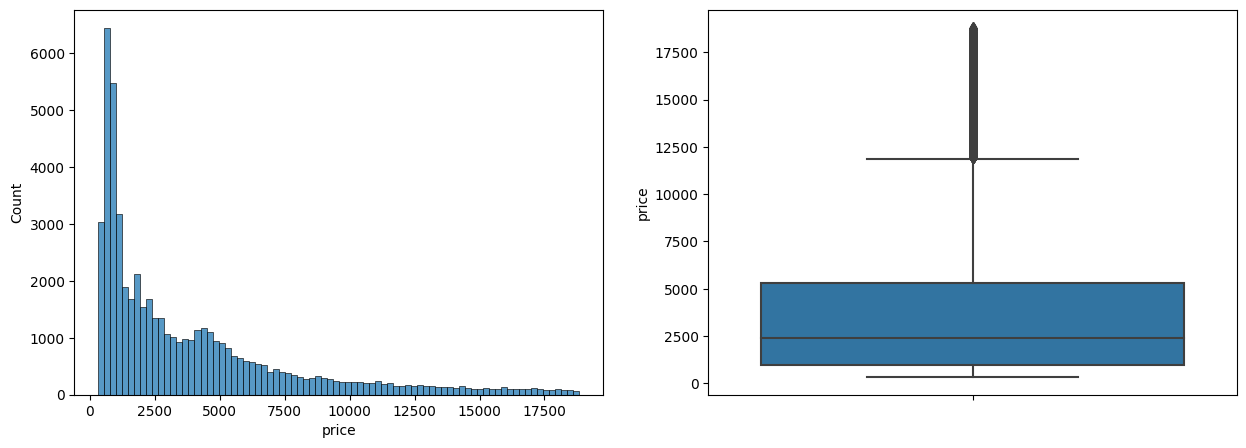

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(data=df, x = 'price', ax=ax[0])
sns.boxplot(data=df, y = 'price', ax=ax[1])
plt.show()

In [27]:
X = df.drop('price', axis=1)
y = df['price']

# transform the y to log scale
y = np.log1p(y) # this log1p will remove the skewness of the data and make it more normal distribution for better prediction

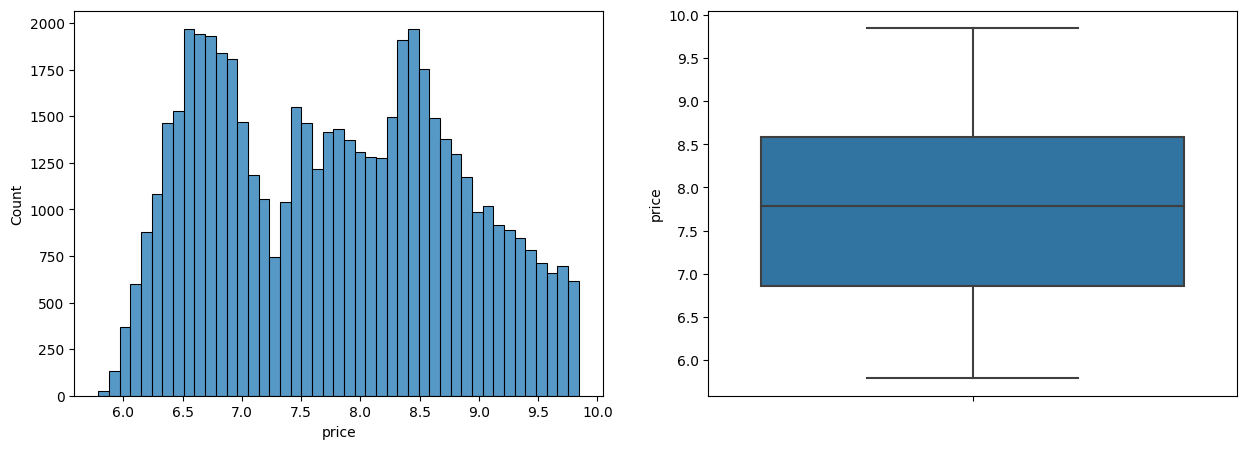

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(x = y, ax=ax[0])
sns.boxplot(y = y, ax=ax[1])
plt.show()

In [29]:
y = df['price']
qt = QuantileTransformer()
y_trans = qt.fit_transform(y.values.reshape(-1,1)).flatten()

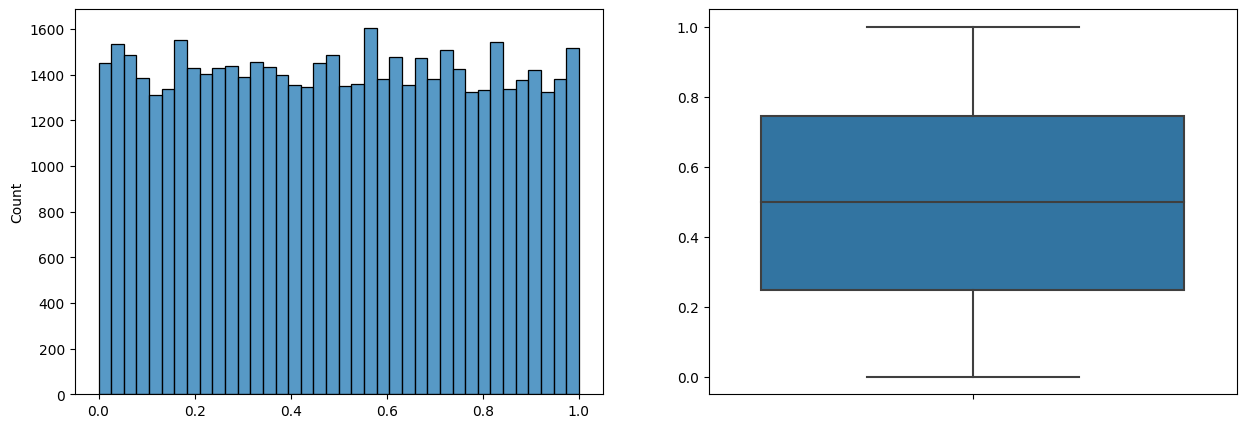

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(x = y_trans, ax=ax[0])
sns.boxplot(y = y_trans, ax=ax[1])
plt.show()

back to model pipeline creation

In [31]:
X = df.drop('price', axis=1)
y = df['price']

In [32]:
cat_cols = df.select_dtypes(exclude='number').columns
num_cols = df.select_dtypes('number').columns
num_cols = num_cols.drop('price')
print(cat_cols)
print(num_cols)

Index(['cut', 'color', 'clarity'], dtype='object')
Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')


In [33]:
cat_pipe = Pipeline([('oe', OrdinalEncoder())])
num_pipe = Pipeline([('sc', StandardScaler())])
transformer = ColumnTransformer([
    ('categorical', cat_pipe, cat_cols),
    ('numerical', num_pipe, num_cols),
])
transformer

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('oe', OrdinalEncoder())]),
                                 Index(['cut', 'color', 'clarity'], dtype='object')),
                                ('numerical',
                                 Pipeline(steps=[('sc', StandardScaler())]),
                                 Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])

In [34]:
model_pipe = Pipeline([
    ('transformer', transformer),
    ('model', RandomForestRegressor(max_depth=10))
])
model_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('oe',
                                                                   OrdinalEncoder())]),
                                                  Index(['cut', 'color', 'clarity'], dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('sc',
                                                                   StandardScaler())]),
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                ('model', RandomForestRegressor(max_depth=10))])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)
model_pipe.fit(X_train, y_train)
y_pred = model_pipe.predict(X_test)
# metrics
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))

MAE: 0.024313417338353047
MSE: 0.0010673826897453964


In [36]:
print("score", r2_score(y_test, y_pred))

score 0.9872444804840819


In [37]:
result = model_pipe.predict(X_test[:10])

In [38]:
qt.inverse_transform(result.reshape(-1,1))

array([[ 513.87285221],
       [2399.47661358],
       [1131.99311895],
       [1223.44633083],
       [8692.12126904],
       [4437.44169773],
       [1743.75840699],
       [1825.15469191],
       [2152.34258849],
       [5928.67544082]])

In [39]:
qt.inverse_transform(y_test[:10].reshape(-1,1))

array([[ 559.],
       [2201.],
       [1238.],
       [1304.],
       [6901.],
       [3011.],
       [1765.],
       [1679.],
       [2102.],
       [4789.]])

In [40]:
from joblib import dump

In [41]:
dump({
    'model': model_pipe,
    'quantile': qt,
    'description': 'diamond price prediction'
}, 'diamond_price.joblib')


['diamond_price.joblib']

- add a train and test error evaluation
- validation curve analysis
- grid search for hyperparameter tuning